<font color=blue>
Supriya Raman & Dharvi Kumra <br>
29th June, 2020
    </font>

# <font color=navy> Gesture Recognition

### <font color=orange> Problem Statement </font>
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
- Thumbs up: Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds
- Stop: Pause the movie

Each video is a sequence of 30 frames (or images)

### <font color=orange> About the Dataset </font>
The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

The data contains a 'train' and a 'val' folder with two CSV files for the two folders.

### <font color= orange>Table of Contents 
<a href='#Step 1'> Step 1: Importing Python Libraries </a> <br>
<a href='#Step 2'> Step 2: Setting the Parameters </a> <br>
<a href='#Step 3'> Step 3: Plotting the Graph </a> <br>
<a href='#Step 4'> Step 4: Generator Function </a> <br>
<a href='#Step 5'> Step 5: Model Definition </a> <br>
<t> <a href='#Step Type1'> Model Type 1: 2D Conv model with RNN models </a> <br>
<t> <a href='#Step 1A'> Model 1A: 2D Conv model with Vanilla RNN as the RNN model </a> <br>
<a href='#Step 1B'> Model 1B: 2D Conv model with GRU as the RNN model - Dropout after each layer and no BatchNormalization </a> <br>
<a href='#Step 1C'> Model 1C: 2D Conv model with GRU as the RNN model - Dropout after dense layer and added BatchNormalization </a> <br>
<a href='#Step 1D'> Model 1D: 2D Conv model with GRU as the RNN model - Using L1 regularization  </a> <br>
<a href='#Step 1E'> Model 1E: 2D Conv model with GRU as the RNN model - Using L2 regularization  </a> <br>
<a href='#Step 1F'> Model 1F: 2D Conv model with LSTM as the RNN model </a> <br>
<a href='#Step 1G'> Model 1G: 2D Conv model with Bidirectional LSTM as the RNN model </a> <br>

<t> <a href='#Step Type2'> Model Type 2: 3D Conv model </a> <br>
<t> <a href='#Step 2A'> Model 2A: 3D Conv model with default arguments and batch_size=11 </a> <br>
<a href='#Step 2B'> Model 2B: 3D Conv model with image dimesion 100 by 100 and batch_size=20 </a> <br>
<a href='#Step 2C'> Model 2C: 3D Conv model without DropOuts </a> <br>
<a href='#Step 2D'> Model 2D: 3D Conv model wit DropOuts and without Batch Normalization </a> <br>

### <font color=orange> 1. Importing Python Libraries <a id='Step 1'></a> </font>

In [2]:
import numpy as np
import os
from PIL import Image
from matplotlib.pyplot import imread
from scipy.misc import imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
from matplotlib import pyplot as plt

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.layers.recurrent import LSTM, GRU
from keras.optimizers import Adam
from keras.regularizers import l1, l2

Using TensorFlow backend.


### <font color=orange> 2. Setting the parameters <a id='Step 2'></a> </font>

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In [5]:
## Number of categories
nb_classes = 5

In [6]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())

### <font color=orange> 3. Plotting <a id='Step 3'></a> </font>

In [7]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### <font color=orange> 4. Generator <a id='Step 4'></a> </font>
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, we preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
print(np.round(np.linspace(0, 29,20)).astype(int))

[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]


In [9]:
def generator(source_path, folder_list, batch_size=11,frames=30,rows=120, cols=120, channel=3):
    img_idx = np.round(np.linspace(0, 29, 20)).astype(int)
    print(enumerate(img_idx))
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches):
            print(batch)
            # we iterate over the number of batches
            batch_data = np.zeros((batch_size,frames,rows,cols,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,nb_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized=imresize(image,(rows,cols,channel))
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        left_data = len(t)%batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,frames,rows,cols,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,nb_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized=imresize(image,(rows,cols,channel))
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). 

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print(num_train_sequences)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

663
# training sequences = 663
# validation sequences = 100
# epochs = 20


### <font color=orange> 5. Model <a id='Step 5'></a> </font>
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.02, patience=4, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)# write the REducelronplateau code here

### <font color=blue size=5> <u>MODEL 1: 2D Conv model with RNN <a id='Step Type1'>

### <font color=green> <u> Model 1A: 2D Conv model with Vanilla RNN as the RNN model <a id='Step 1A'></a> 

In [13]:
def Conv2DVanillaRNN(frames, rows, cols, channel):
    nb_featuremap = [16,32,64,128,256]
    nb_dense = [128,5]
    # Input
    input_shape=(frames,rows,cols,channel)

    rnn_model = Sequential()

    rnn_model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), activation='relu', padding='same'), input_shape=input_shape))

    rnn_model.add(TimeDistributed(BatchNormalization()))
    rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    rnn_model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
    rnn_model.add(TimeDistributed(BatchNormalization()))
    rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    rnn_model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
    rnn_model.add(TimeDistributed(BatchNormalization()))
    rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

    rnn_model.add(TimeDistributed(Conv2D(nb_featuremap[3], (3,3),padding='same', activation='relu')))
    rnn_model.add(TimeDistributed(BatchNormalization()))
    rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    rnn_model.add(TimeDistributed(Conv2D(nb_featuremap[4], (3,3),padding='same', activation='relu')))
    rnn_model.add(TimeDistributed(BatchNormalization()))
    rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

    rnn_model.add(TimeDistributed(Flatten()))

    ## using Vanilla RNN as the RNN model along with softmax as our last layer.
    rnn_model.add(SimpleRNN(128, return_sequences=False))
    rnn_model.add(Dropout(0.25))
    
    rnn_model.add(Dense(nb_dense[0], activation='relu'))
    rnn_model.add(Dropout(0.25))
    
    rnn_model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
    return rnn_model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [14]:
rnn_model = Conv2DVanillaRNN(frames=30,rows=120, cols=120, channel=3)
optimiser =Adam(lr=0.0002) #write your optimizer
rnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (rnn_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 30, 30, 64)    18496     
__________

In [15]:
callbacks_list = [checkpoint, LR]

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
batch_size = 11
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
rnn_training = rnn_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,use_multiprocessing=True)

0
0
Epoch 1/30
1
1
2
2
3
3
4
4
5
5
6
 7/61 [==>...........................] - ETA: 3:20 - loss: 1.8251 - categorical_accuracy: 0.22088
9
61/61 [==============================] - 196s 3s/step - loss: 1.7908 - categorical_accuracy: 0.2042 - val_loss: 1.6113 - val_categorical_accuracy: 0.1818

Epoch 00001: saving model to model_init_2020-06-2807_23_37.369384/model-00001-1.79077-0.20417-1.61134-0.18182.h5
Epoch 2/30
60/61 [============================>.] - ETA: 1s - loss: 1.7604 - categorical_accuracy: 0.18642
2
3
4
3
4
5
6
5
7
6
61/61 [==============================] - 84s 1s/step - loss: 1.7609 - categorical_accuracy: 0.1863 - val_loss: 1.6267 - val_categorical_accuracy: 0.1727

Epoch 00002: saving model to model_init_2020-06-2807_23_37.369384/model-00002-1.76089-0.18629-1.62671-0.17273.h5
Epoch 3/30
8
7
 1/61 [..............................] - ETA: 1:06 - loss: 1.6787 - categorical_accuracy: 0.36368
9
61/61 [==============================] - 88s 1s/step - loss: 1.7215 - categorical_accu

61/61 [==============================] - 85s 1s/step - loss: 1.6731 - categorical_accuracy: 0.2057 - val_loss: 1.6087 - val_categorical_accuracy: 0.2182

Epoch 00005: saving model to model_init_2020-06-2807_23_37.369384/model-00005-1.67305-0.20566-1.60866-0.21818.h5
Epoch 6/30
60/61 [============================>.] - ETA: 1s - loss: 1.7044 - categorical_accuracy: 0.19856
6
7
8
7
9
8
10
11
12
61/61 [==============================] - 85s 1s/step - loss: 1.7065 - categorical_accuracy: 0.1967 - val_loss: 1.6213 - val_categorical_accuracy: 0.2182

Epoch 00006: saving model to model_init_2020-06-2807_23_37.369384/model-00006-1.70646-0.19672-1.62134-0.21818.h5
Epoch 7/30
13
60/61 [============================>.] - ETA: 1s - loss: 1.6549 - categorical_accuracy: 0.22270
1
2
61/61 [==============================] - 87s 1s/step - loss: 1.6542 - categorical_accuracy: 0.2235 - val_loss: 1.6169 - val_categorical_accuracy: 0.1545

Epoch 00007: saving model to model_init_2020-06-2807_23_37.369384/mode

3
60/61 [============================>.] - ETA: 1s - loss: 1.6692 - categorical_accuracy: 0.16978
8
9
10
11
12
13
14
61/61 [==============================] - 86s 1s/step - loss: 1.6707 - categorical_accuracy: 0.1699 - val_loss: 1.6108 - val_categorical_accuracy: 0.2364

Epoch 00008: saving model to model_init_2020-06-2807_23_37.369384/model-00008-1.67073-0.16990-1.61076-0.23636.h5
Epoch 9/30
60/61 [============================>.] - ETA: 1s - loss: 1.6400 - categorical_accuracy: 0.20910
1
2
3
4
61/61 [==============================] - 84s 1s/step - loss: 1.6410 - categorical_accuracy: 0.2072 - val_loss: 1.6096 - val_categorical_accuracy: 0.2273

Epoch 00009: saving model to model_init_2020-06-2807_23_37.369384/model-00009-1.64104-0.20715-1.60958-0.22727.h5

Epoch 00009: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 10/30
5
60/61 [============================>.] - ETA: 1s - loss: 1.6541 - categorical_accuracy: 0.203010
11
12
13
14
15
16
61/61 [=================

60/61 [============================>.] - ETA: 1s - loss: 1.6478 - categorical_accuracy: 0.19244
5
6
7
8
61/61 [==============================] - 85s 1s/step - loss: 1.6488 - categorical_accuracy: 0.1908 - val_loss: 1.6129 - val_categorical_accuracy: 0.2273

Epoch 00013: saving model to model_init_2020-06-2807_23_37.369384/model-00013-1.64881-0.19076-1.61295-0.22727.h5
Epoch 14/30
60/61 [============================>.] - ETA: 1s - loss: 1.6570 - categorical_accuracy: 0.171214
15
16
17
18
19
0
20
61/61 [==============================] - 85s 1s/step - loss: 1.6548 - categorical_accuracy: 0.1759 - val_loss: 1.6097 - val_categorical_accuracy: 0.2364

Epoch 00014: saving model to model_init_2020-06-2807_23_37.369384/model-00014-1.65475-0.17586-1.60974-0.23636.h5
Epoch 15/30
1
21
 3/61 [>.............................] - ETA: 1:03 - loss: 1.6442 - categorical_accuracy: 0.212123
3
 7/61 [==>...........................] - ETA: 58s - loss: 1.6035 - categorical_accuracy: 0.22085
26
60/61 [========

60/61 [============================>.] - ETA: 1s - loss: 1.6448 - categorical_accuracy: 0.212118
19
0
1
20
21
2
22
3
23
4
24
61/61 [==============================] - 85s 1s/step - loss: 1.6439 - categorical_accuracy: 0.2131 - val_loss: 1.6102 - val_categorical_accuracy: 0.2455

Epoch 00018: saving model to model_init_2020-06-2807_23_37.369384/model-00018-1.64391-0.21311-1.61024-0.24545.h5
Epoch 19/30
5
 4/61 [>.............................] - ETA: 57s - loss: 1.5969 - categorical_accuracy: 0.13647
27
61/61 [==============================] - 87s 1s/step - loss: 1.6252 - categorical_accuracy: 0.2131 - val_loss: 1.6126 - val_categorical_accuracy: 0.2273

Epoch 00019: saving model to model_init_2020-06-2807_23_37.369384/model-00019-1.62515-0.21311-1.61259-0.22727.h5
Epoch 20/30
60/61 [============================>.] - ETA: 1s - loss: 1.6305 - categorical_accuracy: 0.218220
2
21
22
3
23
4
24
5
25
6
26
61/61 [==============================] - 87s 1s/step - loss: 1.6300 - categorical_accuracy

61/61 [==============================] - 87s 1s/step - loss: 1.6387 - categorical_accuracy: 0.1908 - val_loss: 1.6109 - val_categorical_accuracy: 0.2364

Epoch 00023: saving model to model_init_2020-06-2807_23_37.369384/model-00023-1.63866-0.19076-1.61085-0.23636.h5
Epoch 24/30
1
60/61 [============================>.] - ETA: 1s - loss: 1.6400 - categorical_accuracy: 0.206124
6
25
26
7
27
8
28
29
30
61/61 [==============================] - 86s 1s/step - loss: 1.6395 - categorical_accuracy: 0.2072 - val_loss: 1.6128 - val_categorical_accuracy: 0.2273

Epoch 00024: saving model to model_init_2020-06-2807_23_37.369384/model-00024-1.63955-0.20715-1.61276-0.22727.h5
Epoch 25/30
31
60/61 [============================>.] - ETA: 1s - loss: 1.6221 - categorical_accuracy: 0.21210
1
2
61/61 [==============================] - 84s 1s/step - loss: 1.6213 - categorical_accuracy: 0.2146 - val_loss: 1.6109 - val_categorical_accuracy: 0.2182

Epoch 00025: saving model to model_init_2020-06-2807_23_37.369

60/61 [============================>.] - ETA: 1s - loss: 1.6507 - categorical_accuracy: 0.195528
29
30
31
32
33
61/61 [==============================] - 85s 1s/step - loss: 1.6505 - categorical_accuracy: 0.1937 - val_loss: 1.6109 - val_categorical_accuracy: 0.2273

Epoch 00028: saving model to model_init_2020-06-2807_23_37.369384/model-00028-1.65046-0.19374-1.61093-0.22727.h5
Epoch 29/30
34
 5/61 [=>............................] - ETA: 57s - loss: 1.6286 - categorical_accuracy: 0.20000
37
 6/61 [=>............................] - ETA: 58s - loss: 1.6374 - categorical_accuracy: 0.181838
1
60/61 [============================>.] - ETA: 1s - loss: 1.6366 - categorical_accuracy: 0.21672
3
4
5
6
61/61 [==============================] - 84s 1s/step - loss: 1.6371 - categorical_accuracy: 0.2146 - val_loss: 1.6118 - val_categorical_accuracy: 0.2364

Epoch 00029: saving model to model_init_2020-06-2807_23_37.369384/model-00029-1.63714-0.21461-1.61180-0.23636.h5
Epoch 30/30
7
60/61 [==============

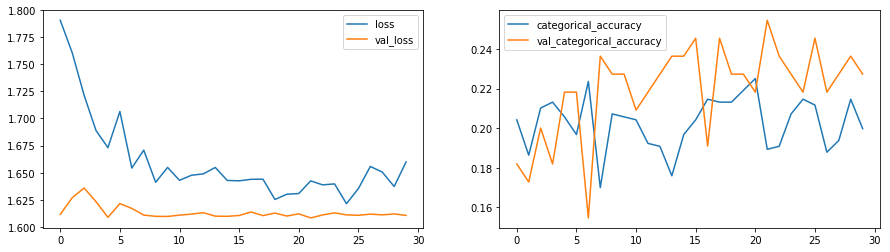

In [20]:
plot(rnn_training)

#### <font color= magenta> <u>Finding: </u>  Training Accuracy = 19.97 ; Validation Accuracy = 22.73 </br> 
    

### <font color=green> <u>Model 1B:2D Conv model with GRU as the RNN model - Dropout after each layer and no BatchNormalization <a id='Step 1B'></a> 

In [18]:
def Conv2DGRU(frames,rows,cols,channel):
    #2D Conv model with GRU as the RNN model
    nb_featuremap = [16,32,64,128,256]
    nb_dense = [512,5]
    # Input
    input_shape=(frames,rows,cols,channel)

    gru_model = Sequential()

    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), activation='relu', padding='same'), 
                                  input_shape=input_shape))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))
    
    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))
    
    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))

    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[3], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))

    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[3], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))
    
    gru_model.add(TimeDistributed(Flatten()))
  
    gru_model.add(Dense(nb_dense[0], activation='relu'))
    gru_model.add(Dropout(0.5))
    
    ## using GRU as the RNN model along with softmax as our last layer.
    gru_model.add(GRU(128, return_sequences=False))
    gru_model.add(Dropout(0.25))
    
    gru_model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
    return gru_model

In [19]:
gru_model = Conv2DGRU(frames=30,rows=120,cols=120,channel=3)
optimiser =Adam(0.001) #write your optimizer
gru_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (gru_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 30, 30, 64)    18496     
__________

In [20]:
callbacks_list = [checkpoint, LR]

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [21]:
batch_size = 11
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
    
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [23]:
gru_training = gru_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,use_multiprocessing=True)

0
0
Epoch 1/20
1
1
2
2
3
3
4
4
5
5
6
6
61/61 [==============================] - 187s 3s/step - loss: 1.6128 - categorical_accuracy: 0.1982 - val_loss: 1.6092 - val_categorical_accuracy: 0.2091

Epoch 00001: saving model to model_init_2020-06-2811_32_27.035720/model-00001-1.61278-0.19821-1.60921-0.20909.h5
Epoch 2/20
60/61 [============================>.] - ETA: 1s - loss: 1.6111 - categorical_accuracy: 0.18942
2
3
4
3
5
4
6
7
5
6
61/61 [==============================] - 84s 1s/step - loss: 1.6109 - categorical_accuracy: 0.1893 - val_loss: 1.6097 - val_categorical_accuracy: 0.2273

Epoch 00002: saving model to model_init_2020-06-2811_32_27.035720/model-00002-1.61087-0.18927-1.60967-0.22727.h5
Epoch 3/20
8
 2/61 [..............................] - ETA: 59s - loss: 1.6075 - categorical_accuracy: 0.18189
8
61/61 [==============================] - 85s 1s/step - loss: 1.6108 - categorical_accuracy: 0.2042 - val_loss: 1.6067 - val_categorical_accuracy: 0.2273

Epoch 00003: saving model to mode

61/61 [==============================] - 87s 1s/step - loss: 1.6054 - categorical_accuracy: 0.2027 - val_loss: 1.5971 - val_categorical_accuracy: 0.2636

Epoch 00005: saving model to model_init_2020-06-2811_32_27.035720/model-00005-1.60538-0.20268-1.59709-0.26364.h5
Epoch 6/20
1
60/61 [============================>.] - ETA: 1s - loss: 1.6110 - categorical_accuracy: 0.23186
6
7
8
7
9
8
10
11
61/61 [==============================] - 86s 1s/step - loss: 1.6108 - categorical_accuracy: 0.2325 - val_loss: 1.6124 - val_categorical_accuracy: 0.2000

Epoch 00006: saving model to model_init_2020-06-2811_32_27.035720/model-00006-1.61084-0.23249-1.61239-0.20000.h5
Epoch 7/20
12
60/61 [============================>.] - ETA: 1s - loss: 1.6114 - categorical_accuracy: 0.20000
1
2
61/61 [==============================] - 85s 1s/step - loss: 1.6114 - categorical_accuracy: 0.2012 - val_loss: 1.6097 - val_categorical_accuracy: 0.2000



Epoch 00007: saving model to model_init_2020-06-2811_32_27.035720/model-00007-1.61137-0.20119-1.60974-0.20000.h5
Epoch 8/20
60/61 [============================>.] - ETA: 1s - loss: 1.6112 - categorical_accuracy: 0.17278
8
9
10
11
12
13
61/61 [==============================] - 85s 1s/step - loss: 1.6112 - categorical_accuracy: 0.1729 - val_loss: 1.6080 - val_categorical_accuracy: 0.2182

Epoch 00008: saving model to model_init_2020-06-2811_32_27.035720/model-00008-1.61121-0.17288-1.60802-0.21818.h5
Epoch 9/20
14
60/61 [============================>.] - ETA: 1s - loss: 1.6089 - categorical_accuracy: 0.21210
1
2
3
4
61/61 [==============================] - 86s 1s/step - loss: 1.6095 - categorical_accuracy: 0.2101 - val_loss: 1.6053 - val_categorical_accuracy: 0.2182

Epoch 00009: saving model to model_init_2020-06-2811_32_27.035720/model-00009-1.60950-0.21013-1.60529-0.21818.h5

Epoch 00009: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.
Epoch 10/20
5
60/61 [========

Epoch 11/20
17
 5/61 [=>............................] - ETA: 57s - loss: 1.5971 - categorical_accuracy: 0.272720
0
 7/61 [==>...........................] - ETA: 54s - loss: 1.5979 - categorical_accuracy: 0.25971
21
60/61 [============================>.] - ETA: 1s - loss: 1.5925 - categorical_accuracy: 0.25912
3
4
5
6
61/61 [==============================] - 84s 1s/step - loss: 1.5929 - categorical_accuracy: 0.2563 - val_loss: 1.6032 - val_categorical_accuracy: 0.2455

Epoch 00011: saving model to model_init_2020-06-2811_32_27.035720/model-00011-1.59287-0.25633-1.60320-0.24545.h5
Epoch 12/20
60/61 [============================>.] - ETA: 1s - loss: 1.5907 - categorical_accuracy: 0.228812
13
14
15
16
17
61/61 [==============================] - 86s 1s/step - loss: 1.5908 - categorical_accuracy: 0.2310 - val_loss: 1.6050 - val_categorical_accuracy: 0.2364

Epoch 00012: saving model to model_init_2020-06-2811_32_27.035720/model-00012-1.59081-0.23100-1.60504-0.23636.h5
Epoch 13/20
18
 4/61 [>

60/61 [============================>.] - ETA: 1s - loss: 1.5443 - categorical_accuracy: 0.26066
7
8
61/61 [==============================] - 85s 1s/step - loss: 1.5442 - categorical_accuracy: 0.2623 - val_loss: 1.6058 - val_categorical_accuracy: 0.2273

Epoch 00015: saving model to model_init_2020-06-2811_32_27.035720/model-00015-1.54422-0.26230-1.60583-0.22727.h5
Epoch 16/20
60/61 [============================>.] - ETA: 1s - loss: 1.5190 - categorical_accuracy: 0.295516
17
18
0
19
1
20
2
21
61/61 [==============================] - 84s 1s/step - loss: 1.5227 - categorical_accuracy: 0.2936 - val_loss: 1.6199 - val_categorical_accuracy: 0.2182

Epoch 00016: saving model to model_init_2020-06-2811_32_27.035720/model-00016-1.52274-0.29359-1.61985-0.21818.h5

Epoch 00016: ReduceLROnPlateau reducing learning rate to 4.0000002627493813e-07.
Epoch 17/20
22
3
 2/61 [..............................] - ETA: 1:01 - loss: 1.6313 - categorical_accuracy: 0.04554
23
 4/61 [>............................

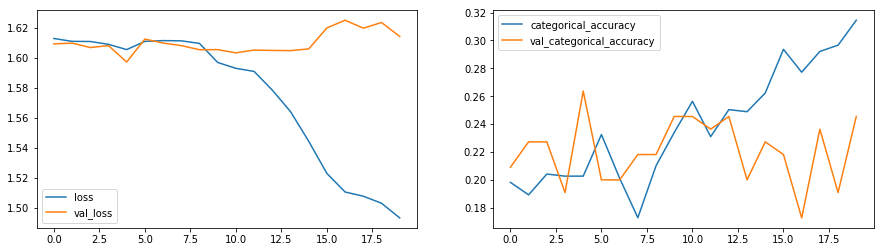

In [24]:
plot(gru_training)

#### <font color= magenta> <u>Finding: </u> Training Accuracy = 31.45 ; Validation Accuracy = 24.55 </n> 

### <font color=green> <u>Model 1C:2D Conv model with GRU as the RNN model - Dropout after dense layer and added BatchNormalization <a id='Step 1C'></a> 

In [31]:
def Conv2DGRU(frames,rows,cols,channel):
    #2D Conv model with GRU as the RNN model
    nb_featuremap = [16,32,64,128,256]
    nb_dense = [512,5]
    # Input
    input_shape=(frames,rows,cols,channel)

    gru_model = Sequential()

    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), activation='relu', padding='same'), 
                                  input_shape=input_shape))

    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))

    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[3], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))

    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[3], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    gru_model.add(TimeDistributed(Flatten()))
  
    gru_model.add(Dense(nb_dense[0], activation='relu'))
    gru_model.add(Dropout(0.5))
    
    ## using GRU as the RNN model along with softmax as our last layer.
    gru_model.add(GRU(128, return_sequences=False))
    gru_model.add(Dropout(0.25))
    
    gru_model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
    return gru_model

In [32]:
gru_model_1 = Conv2DGRU(frames=30,rows=120,cols=120,channel=3)
optimiser =Adam(0.001) #write your optimizer
gru_model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (gru_model_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_44 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_45 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_46 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_47 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_48 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_49 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_50 (TimeDis (None, 30, 30, 30, 64)    18496     
__________

In [33]:
callbacks_list = [checkpoint, LR]

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [34]:
batch_size = 11
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [35]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
    
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [36]:
num_epochs = 20
gru_training_1 = gru_model_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,use_multiprocessing=True)

0
0
Epoch 1/20
1
1
2
2
3
4
3
 3/61 [>.............................] - ETA: 2:40 - loss: 2.2014 - categorical_accuracy: 0.12126
5
 6/61 [=>............................] - ETA: 1:46 - loss: 2.3173 - categorical_accuracy: 0.15158
7
 7/61 [==>...........................] - ETA: 1:38 - loss: 2.3365 - categorical_accuracy: 0.15589
8
61/61 [==============================] - 94s 2s/step - loss: 2.0367 - categorical_accuracy: 0.2072 - val_loss: 2.0365 - val_categorical_accuracy: 0.1545

Epoch 00001: saving model to model_init_2020-06-2811_32_27.035720/model-00001-2.03667-0.20715-2.03647-0.15455.h5
Epoch 2/20
60/61 [============================>.] - ETA: 1s - loss: 1.6339 - categorical_accuracy: 0.32422
2
3
4
3
5
4
6
5
7
6
8
61/61 [==============================] - 83s 1s/step - loss: 1.6388 - categorical_accuracy: 0.3234 - val_loss: 1.6592 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model_init_2020-06-2811_32_27.035720/model-00002-1.63877-0.32340-1.65918-0.30000.h5
Epoch 3/

61/61 [==============================] - 86s 1s/step - loss: 1.3397 - categorical_accuracy: 0.4411 - val_loss: 1.1678 - val_categorical_accuracy: 0.4909

Epoch 00005: saving model to model_init_2020-06-2811_32_27.035720/model-00005-1.33968-0.44113-1.16777-0.49091.h5
Epoch 6/20
1
60/61 [============================>.] - ETA: 1s - loss: 1.3251 - categorical_accuracy: 0.41826
6
7
7
8
8
9
10
11
61/61 [==============================] - 85s 1s/step - loss: 1.3364 - categorical_accuracy: 0.4158 - val_loss: 1.3196 - val_categorical_accuracy: 0.4273
12

Epoch 00006: saving model to model_init_2020-06-2811_32_27.035720/model-00006-1.33640-0.41580-1.31955-0.42727.h5
Epoch 7/20
60/61 [============================>.] - ETA: 1s - loss: 1.3597 - categorical_accuracy: 0.43480
1
2
61/61 [==============================] - 86s 1s/step - loss: 1.3585 - categorical_accuracy: 0.4352 - val_loss: 1.2969 - val_categorical_accuracy: 0.4545



Epoch 00007: saving model to model_init_2020-06-2811_32_27.035720/model-00007-1.35847-0.43517-1.29686-0.45455.h5
Epoch 8/20
3
60/61 [============================>.] - ETA: 1s - loss: 1.2153 - categorical_accuracy: 0.47888
9
8
10
11
12
13
14
61/61 [==============================] - 84s 1s/step - loss: 1.2194 - categorical_accuracy: 0.4784 - val_loss: 1.2717 - val_categorical_accuracy: 0.4364

Epoch 00008: saving model to model_init_2020-06-2811_32_27.035720/model-00008-1.21936-0.47839-1.27165-0.43636.h5
Epoch 9/20
15
60/61 [============================>.] - ETA: 1s - loss: 1.1537 - categorical_accuracy: 0.51670
1
2
3
4
61/61 [==============================] - 84s 1s/step - loss: 1.1462 - categorical_accuracy: 0.5216 - val_loss: 1.2369 - val_categorical_accuracy: 0.4909

Epoch 00009: saving model to model_init_2020-06-2811_32_27.035720/model-00009-1.14625-0.52161-1.23689-0.49091.h5
5

Epoch 00009: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.
Epoch 10/20
60/61 [===

60/61 [============================>.] - ETA: 1s - loss: 0.9959 - categorical_accuracy: 0.59094
5
6
7
8
61/61 [==============================] - 85s 1s/step - loss: 0.9941 - categorical_accuracy: 0.5887 - val_loss: 0.9628 - val_categorical_accuracy: 0.6455

Epoch 00013: saving model to model_init_2020-06-2811_32_27.035720/model-00013-0.99411-0.58867-0.96282-0.64545.h5
Epoch 14/20
60/61 [============================>.] - ETA: 1s - loss: 1.0009 - categorical_accuracy: 0.587914
15
16
17
18
19
0
61/61 [==============================] - 84s 1s/step - loss: 0.9983 - categorical_accuracy: 0.5902 - val_loss: 1.0145 - val_categorical_accuracy: 0.6182

Epoch 00014: saving model to model_init_2020-06-2811_32_27.035720/model-00014-0.99832-0.59016-1.01449-0.61818.h5
Epoch 15/20
20
 1/61 [..............................] - ETA: 1:07 - loss: 1.0669 - categorical_accuracy: 0.54551
21
 4/61 [>.............................] - ETA: 1:03 - loss: 1.2406 - categorical_accuracy: 0.47733
23
60/61 [============

60/61 [============================>.] - ETA: 1s - loss: 0.9657 - categorical_accuracy: 0.613618
0
19
20
1
21
2
22
3
23
24
4
61/61 [==============================] - 84s 1s/step - loss: 0.9601 - categorical_accuracy: 0.6155 - val_loss: 1.0184 - val_categorical_accuracy: 0.6091

Epoch 00018: saving model to model_init_2020-06-2811_32_27.035720/model-00018-0.96006-0.61550-1.01838-0.60909.h5
Epoch 19/20
25
5
 2/61 [..............................] - ETA: 1:06 - loss: 1.1578 - categorical_accuracy: 0.590926
6
61/61 [==============================] - 86s 1s/step - loss: 0.9319 - categorical_accuracy: 0.6438 - val_loss: 1.0518 - val_categorical_accuracy: 0.5818

Epoch 00019: saving model to model_init_2020-06-2811_32_27.035720/model-00019-0.93192-0.64382-1.05181-0.58182.h5
Epoch 20/20
60/61 [============================>.] - ETA: 1s - loss: 0.9481 - categorical_accuracy: 0.589420
2
21
3
22
23
4
24
5
25
6
61/61 [==============================] - 84s 1s/step - loss: 0.9465 - categorical_accurac

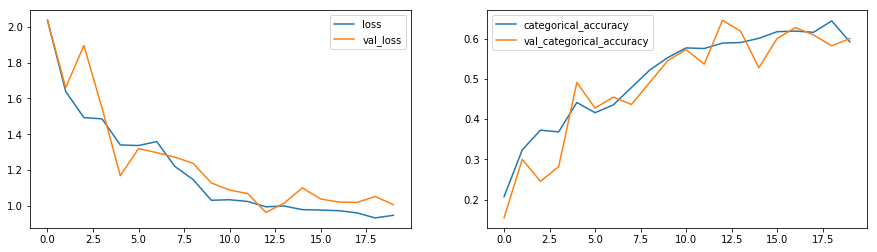

In [45]:
plot(gru_training_1)

#### <font color= magenta> <u>Finding: </u> Highest Training Accuracy achieved in 18th epoch = 71.35% ; Highest Validation Accuracy achieved in 18th epoch = 70.19% </br> 

### <font color=green> <u>Model 1D:2D Conv model with GRU as the RNN model - Using L1 regularization <a id='Step 1D'></a> 

In [60]:
def Conv2DGRU(frames,rows,cols,channel):
    #2D Conv model with GRU as the RNN model
    nb_featuremap = [16,32,64,128,256]
    nb_dense = [512,5]
    # Input
    input_shape=(frames,rows,cols,channel)

    gru_model = Sequential()

    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), activation='relu', padding='same'), 
                                  input_shape=input_shape))

    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))
    
    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))
    
    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))

    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[3], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))

    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[3], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))
    
    gru_model.add(TimeDistributed(Flatten()))
  
    gru_model.add(Dense(nb_dense[0], activation='relu', kernel_regularizer=l1(0.01)))
    gru_model.add(Dropout(0.5))
    
    ## using GRU as the RNN model along with softmax as our last layer.
    gru_model.add(GRU(128, return_sequences=False))
    gru_model.add(Dropout(0.25))
    
    gru_model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
    return gru_model

In [61]:
gru_model_2 = Conv2DGRU(frames=30,rows=120,cols=120,channel=3)
optimiser =Adam(0.001) #write your optimizer
gru_model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (gru_model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_101 (TimeDi (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_102 (TimeDi (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_103 (TimeDi (None, 30, 60, 60, 16)    0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_104 (TimeDi (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_105 (TimeDi (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_106 (TimeDi (None, 30, 30, 30, 32)    0         
__________

In [62]:
callbacks_list = [checkpoint, LR]

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [63]:
batch_size = 11
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [64]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
    
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [65]:
num_epochs = 20
gru_training_2 = gru_model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,use_multiprocessing=True)

0
0
Epoch 1/20
1
1
2
2
3
3
4
4
5
 1/61 [..............................] - ETA: 8:22 - loss: 179.1545 - categorical_accuracy: 0.09095
6
 2/61 [..............................] - ETA: 4:41 - loss: 177.7763 - categorical_accuracy: 0.13646
7
 4/61 [>.............................] - ETA: 2:47 - loss: 174.7090 - categorical_accuracy: 0.18187
8
61/61 [==============================] - 95s 2s/step - loss: 91.2070 - categorical_accuracy: 0.2295 - val_loss: 26.5183 - val_categorical_accuracy: 0.2273

Epoch 00001: saving model to model_init_2020-06-2811_32_27.035720/model-00001-91.20697-0.22951-26.51830-0.22727.h5
Epoch 2/20
0
60/61 [============================>.] - ETA: 1s - loss: 11.2113 - categorical_accuracy: 0.32122
2
3
4
3
5
4
6
5
7
6
8
61/61 [==============================] - 81s 1s/step - loss: 11.1069 - categorical_accuracy: 0.3219 - val_loss: 6.1091 - val_categorical_accuracy: 0.2273

Epoch 00002: saving model to model_init_2020-06-2811_32_27.035720/model-00002-11.10687-0.32191-6.10908-

61/61 [==============================] - 86s 1s/step - loss: 2.8514 - categorical_accuracy: 0.3875 - val_loss: 3.8864 - val_categorical_accuracy: 0.2000

Epoch 00005: saving model to model_init_2020-06-2811_32_27.035720/model-00005-2.85144-0.38748-3.88643-0.20000.h5
Epoch 6/20
1
60/61 [============================>.] - ETA: 1s - loss: 2.7800 - categorical_accuracy: 0.39706
6
7
8
7
9
8
10
11
61/61 [==============================] - 86s 1s/step - loss: 2.7743 - categorical_accuracy: 0.3979 - val_loss: 3.8914 - val_categorical_accuracy: 0.2364
12

Epoch 00006: saving model to model_init_2020-06-2811_32_27.035720/model-00006-2.77428-0.39791-3.89145-0.23636.h5
Epoch 7/20
60/61 [============================>.] - ETA: 1s - loss: 2.4479 - categorical_accuracy: 0.40450
1
2
61/61 [==============================] - 84s 1s/step - loss: 2.4469 - categorical_accuracy: 0.4083 - val_loss: 4.0563 - val_categorical_accuracy: 0.2000

Epoch 00007: saving model to model_init_2020-06-2811_32_27.035720/model

 5/61 [=>............................] - ETA: 1:02 - loss: 2.6598 - categorical_accuracy: 0.32730
20
60/61 [============================>.] - ETA: 1s - loss: 2.3458 - categorical_accuracy: 0.43642
3
4
5
61/61 [==============================] - 85s 1s/step - loss: 2.3400 - categorical_accuracy: 0.4352 - val_loss: 2.8745 - val_categorical_accuracy: 0.2273
6

Epoch 00011: saving model to model_init_2020-06-2811_32_27.035720/model-00011-2.34001-0.43517-2.87447-0.22727.h5
Epoch 12/20
60/61 [============================>.] - ETA: 1s - loss: 2.2939 - categorical_accuracy: 0.448512
13
14
15
16
17
18
61/61 [==============================] - 86s 1s/step - loss: 2.2970 - categorical_accuracy: 0.4471 - val_loss: 3.5005 - val_categorical_accuracy: 0.2000

Epoch 00012: saving model to model_init_2020-06-2811_32_27.035720/model-00012-2.29703-0.44709-3.50050-0.20000.h5
Epoch 13/20
19
 4/61 [>.............................] - ETA: 1:05 - loss: 2.5026 - categorical_accuracy: 0.43181
22
 6/61 [=>.........

60/61 [============================>.] - ETA: 1s - loss: 2.4575 - categorical_accuracy: 0.54396
7
8
61/61 [==============================] - 86s 1s/step - loss: 2.4530 - categorical_accuracy: 0.5455 - val_loss: 2.6989 - val_categorical_accuracy: 0.4364

Epoch 00015: saving model to model_init_2020-06-2811_32_27.035720/model-00015-2.45299-0.54545-2.69892-0.43636.h5
Epoch 16/20
60/61 [============================>.] - ETA: 1s - loss: 2.2545 - categorical_accuracy: 0.530316
17
18
19
0
20
1
21
2
61/61 [==============================] - 85s 1s/step - loss: 2.2556 - categorical_accuracy: 0.5291 - val_loss: 2.5893 - val_categorical_accuracy: 0.4000

Epoch 00016: saving model to model_init_2020-06-2811_32_27.035720/model-00016-2.25559-0.52906-2.58933-0.40000.h5
Epoch 17/20
3
22
 1/61 [..............................] - ETA: 1:03 - loss: 1.8607 - categorical_accuracy: 0.63644
23
 3/61 [>.............................] - ETA: 1:04 - loss: 1.8507 - categorical_accuracy: 0.636424
5
 4/61 [>.........

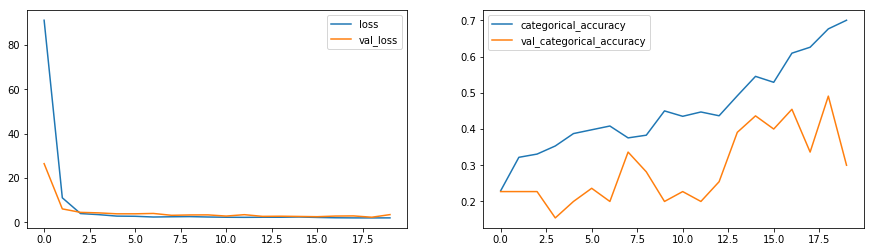

In [66]:
plot(gru_training_2)

#### <font color= magenta> <u>Finding: </u>Highest Training Accuracy achieved  in 20th epoch = 75% ; Highest Validation Accuracy achieved in 20th epoch = 58% </br> 

### <font color=green> <u>Model 1E:2D Conv model with GRU as the RNN model - Using L2 Regularization <a id='Step 1E'></a> 

In [47]:
def Conv2DGRU(frames,rows,cols,channel):
    #2D Conv model with GRU as the RNN model
    nb_featuremap = [16,32,64,128,256]
    nb_dense = [512,5]
    # Input
    input_shape=(frames,rows,cols,channel)

    gru_model = Sequential()

    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), activation='relu', padding='same'), 
                                  input_shape=input_shape))

    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))
    
    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))
    
    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))

    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[3], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))

    gru_model.add(TimeDistributed(Conv2D(nb_featuremap[3], (3,3),padding='same', activation='relu')))
    gru_model.add(TimeDistributed(BatchNormalization()))
    gru_model.add(TimeDistributed(MaxPooling2D((2, 2))))
    gru_model.add(Dropout(0.25))
    
    gru_model.add(TimeDistributed(Flatten()))
  
    gru_model.add(Dense(nb_dense[0], activation='relu', kernel_regularizer=l2(0.01)))
    gru_model.add(Dropout(0.5))
    
    ## using GRU as the RNN model along with softmax as our last layer.
    gru_model.add(GRU(128, return_sequences=False))
    gru_model.add(Dropout(0.25))
    
    gru_model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
    return gru_model

In [48]:
gru_model_3 = Conv2DGRU(frames=30,rows=120,cols=120,channel=3)
optimiser =Adam(0.001) #write your optimizer
gru_model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (gru_model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_76 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_77 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_78 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_79 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_80 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_81 (TimeDis (None, 30, 30, 30, 32)    0         
__________

In [49]:
callbacks_list = [checkpoint, LR]

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [50]:
batch_size = 11
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [51]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
    
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [52]:
num_epochs = 20
gru_training_3 = gru_model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,use_multiprocessing=True)

0
0
Epoch 1/20
1
1
2
2
3
3
4
4
 1/61 [..............................] - ETA: 7:35 - loss: 9.0858 - categorical_accuracy: 0.27275
5
 4/61 [>.............................] - ETA: 2:35 - loss: 9.4273 - categorical_accuracy: 0.25007
7
17/61 [=======>......................] - ETA: 1:07 - loss: 8.8748 - categorical_accuracy: 0.251318
19
61/61 [==============================] - 94s 2s/step - loss: 8.0797 - categorical_accuracy: 0.2355 - val_loss: 7.0488 - val_categorical_accuracy: 0.2545

Epoch 00001: saving model to model_init_2020-06-2811_32_27.035720/model-00001-8.07972-0.23547-7.04879-0.25455.h5
Epoch 2/20
60/61 [============================>.] - ETA: 1s - loss: 6.1048 - categorical_accuracy: 0.35912
2
3
4
3
5
4
6
5
7
6
61/61 [==============================] - 81s 1s/step - loss: 6.0885 - categorical_accuracy: 0.3607 - val_loss: 5.9246 - val_categorical_accuracy: 0.2273

Epoch 00002: saving model to model_init_2020-06-2811_32_27.035720/model-00002-6.08850-0.36066-5.92456-0.22727.h5
Epoch 

60/61 [============================>.] - ETA: 1s - loss: 3.2091 - categorical_accuracy: 0.43330
1
61/61 [==============================] - 86s 1s/step - loss: 3.1970 - categorical_accuracy: 0.4352 - val_loss: 3.8293 - val_categorical_accuracy: 0.1909

Epoch 00005: saving model to model_init_2020-06-2811_32_27.035720/model-00005-3.19702-0.43517-3.82927-0.19091.h5
Epoch 6/20
60/61 [============================>.] - ETA: 1s - loss: 2.7589 - categorical_accuracy: 0.40916
7
6
8
7
9
8
10
11
12
61/61 [==============================] - 86s 1s/step - loss: 2.7510 - categorical_accuracy: 0.4098 - val_loss: 3.2003 - val_categorical_accuracy: 0.2182

Epoch 00006: saving model to model_init_2020-06-2811_32_27.035720/model-00006-2.75102-0.40984-3.20031-0.21818.h5
Epoch 7/20
13
60/61 [============================>.] - ETA: 1s - loss: 2.2747 - categorical_accuracy: 0.46670
1
2
61/61 [==============================] - 85s 1s/step - loss: 2.2671 - categorical_accuracy: 0.4694 - val_loss: 3.5710 - val_ca

3
60/61 [============================>.] - ETA: 1s - loss: 1.9605 - categorical_accuracy: 0.53338
8
9
10
11
12
13
14
61/61 [==============================] - 86s 1s/step - loss: 1.9512 - categorical_accuracy: 0.5365 - val_loss: 4.6531 - val_categorical_accuracy: 0.1818

Epoch 00008: saving model to model_init_2020-06-2811_32_27.035720/model-00008-1.95124-0.53651-4.65312-0.18182.h5
Epoch 9/20
15
60/61 [============================>.] - ETA: 1s - loss: 1.7573 - categorical_accuracy: 0.57580
1
2
3
4
61/61 [==============================] - 85s 1s/step - loss: 1.7510 - categorical_accuracy: 0.5782 - val_loss: 3.5049 - val_categorical_accuracy: 0.2182

Epoch 00009: saving model to model_init_2020-06-2811_32_27.035720/model-00009-1.75098-0.57824-3.50494-0.21818.h5
Epoch 10/20
5
60/61 [============================>.] - ETA: 1s - loss: 1.5754 - categorical_accuracy: 0.622710
11
12
13
14
15
16
61/61 [==============================] - 83s 1s/step - loss: 1.5853 - categorical_accuracy: 0.6170 - v

60/61 [============================>.] - ETA: 1s - loss: 1.2899 - categorical_accuracy: 0.71974
5
6
7
8
61/61 [==============================] - 84s 1s/step - loss: 1.2894 - categorical_accuracy: 0.7198 - val_loss: 5.3105 - val_categorical_accuracy: 0.1909

Epoch 00013: saving model to model_init_2020-06-2811_32_27.035720/model-00013-1.28943-0.71982-5.31047-0.19091.h5
Epoch 14/20
60/61 [============================>.] - ETA: 1s - loss: 1.2743 - categorical_accuracy: 0.707614
15
16
17
18
19
0
20
61/61 [==============================] - 84s 1s/step - loss: 1.2708 - categorical_accuracy: 0.7109 - val_loss: 4.9951 - val_categorical_accuracy: 0.2182

Epoch 00014: saving model to model_init_2020-06-2811_32_27.035720/model-00014-1.27079-0.71088-4.99511-0.21818.h5
Epoch 15/20
1
21
 1/61 [..............................] - ETA: 1:08 - loss: 1.0998 - categorical_accuracy: 0.90912
22
 3/61 [>.............................] - ETA: 1:05 - loss: 1.4076 - categorical_accuracy: 0.60613
23
 4/61 [>......

60/61 [============================>.] - ETA: 1s - loss: 1.2391 - categorical_accuracy: 0.719718
0
19
20
1
21
2
22
3
23
4
24
61/61 [==============================] - 85s 1s/step - loss: 1.2387 - categorical_accuracy: 0.7213 - val_loss: 4.5681 - val_categorical_accuracy: 0.2364

Epoch 00018: saving model to model_init_2020-06-2811_32_27.035720/model-00018-1.23870-0.72131-4.56812-0.23636.h5
Epoch 19/20
25
5
 2/61 [..............................] - ETA: 1:07 - loss: 1.2402 - categorical_accuracy: 0.68186
26
 5/61 [=>............................] - ETA: 1:01 - loss: 1.2786 - categorical_accuracy: 0.69098
28
61/61 [==============================] - 85s 1s/step - loss: 1.2268 - categorical_accuracy: 0.7332 - val_loss: 4.7523 - val_categorical_accuracy: 0.2000

Epoch 00019: saving model to model_init_2020-06-2811_32_27.035720/model-00019-1.22676-0.73323-4.75230-0.20000.h5
Epoch 20/20
60/61 [============================>.] - ETA: 1s - loss: 1.1948 - categorical_accuracy: 0.756120
21
2
22
3
23


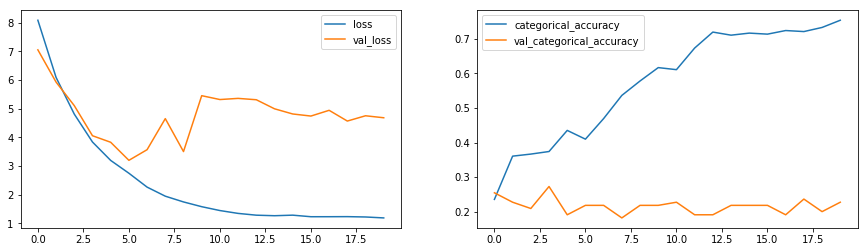

In [53]:
plot(gru_training_3)

#### <font color= magenta> <u>Finding: </u> Highest Training Accuracy in 18th epoch = 72%  ; Highest Validation Accuracy achieved in 18th epoch = 23% </br> 

### <font color=green> <u>Model 1F: 2D Conv model with LSTM as the RNN model <a id='Step 1F'></a> 

In [12]:
def Conv2DLSTM(frames,rows,cols,channel):
    #2D Conv model with GRU as the RNN model 
    nb_featuremap = [8,16,32,64]
    nb_dense = [128,64,5]
    # Input
    input_shape=(frames,rows,cols,channel)

    lstm_model = Sequential()

    lstm_model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))


    lstm_model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
    lstm_model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    lstm_model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
    lstm_model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    lstm_model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
    lstm_model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    lstm_model.add(TimeDistributed(BatchNormalization()))
    lstm_model.add(Dropout(0.25))

    lstm_model.add(TimeDistributed(Flatten()))

    lstm_model.add(Dense(nb_dense[0], activation='relu'))
    lstm_model.add(Dropout(0.25))
    lstm_model.add(Dense(nb_dense[1], activation='relu'))
    lstm_model.add(Dropout(0.25))

    ## using LSTM as the RNN model along with softmax as our last layer.
    lstm_model.add(LSTM(128, return_sequences=False))
    lstm_model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
    return lstm_model

In [13]:
lstm_model = Conv2DLSTM(frames=30, rows=120,cols=120,channel=3)
optimiser =Adam(0.001) #write your optimizer
lstm_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (lstm_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 64)    8256      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 7, 7, 64)      0         
__________

In [14]:
callbacks_list = [checkpoint, LR]

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
batch_size = 11
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [17]:
lstm_training = lstm_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,use_multiprocessing=True)

0
0
Epoch 1/20
1
1
2
2
3
3
4
4
5
5
 1/61 [..............................] - ETA: 18:51 - loss: 1.7324 - categorical_accuracy: 0.09096
6
 7/61 [==>...........................] - ETA: 3:04 - loss: 1.6354 - categorical_accuracy: 0.31178
8
61/61 [==============================] - 183s 3s/step - loss: 1.4749 - categorical_accuracy: 0.3145 - val_loss: 1.4521 - val_categorical_accuracy: 0.3364

Epoch 00001: saving model to model_init_2020-06-2816_01_29.030839/model-00001-1.47489-0.31446-1.45208-0.33636.h5
Epoch 2/20
60/61 [============================>.] - ETA: 1s - loss: 1.2681 - categorical_accuracy: 0.41972
2
3
4
3
5
4
6
5
7
61/61 [==============================] - 84s 1s/step - loss: 1.2613 - categorical_accuracy: 0.4247 - val_loss: 1.2623 - val_categorical_accuracy: 0.5364
6

Epoch 00002: saving model to model_init_2020-06-2816_01_29.030839/model-00002-1.26130-0.42474-1.26231-0.53636.h5
Epoch 3/20
8
61/61 [==============================] - 85s 1s/step - loss: 1.1915 - categorical_accurac

61/61 [==============================] - 83s 1s/step - loss: 1.0663 - categorical_accuracy: 0.5440 - val_loss: 1.9218 - val_categorical_accuracy: 0.3727

Epoch 00005: saving model to model_init_2020-06-2816_01_29.030839/model-00005-1.06629-0.54396-1.92185-0.37273.h5
Epoch 6/20
60/61 [============================>.] - ETA: 1s - loss: 0.9502 - categorical_accuracy: 0.62736
6
7
7
8
9
8
10
11
61/61 [==============================] - 83s 1s/step - loss: 0.9545 - categorical_accuracy: 0.6274 - val_loss: 1.6177 - val_categorical_accuracy: 0.4818

Epoch 00006: saving model to model_init_2020-06-2816_01_29.030839/model-00006-0.95447-0.62742-1.61766-0.48182.h5
Epoch 7/20
60/61 [============================>.] - ETA: 1s - loss: 0.8248 - categorical_accuracy: 0.67120
1
61/61 [==============================] - 84s 1s/step - loss: 0.8282 - categorical_accuracy: 0.6721 - val_loss: 1.5270 - val_categorical_accuracy: 0.4727

Epoch 00007: saving model to model_init_2020-06-2816_01_29.030839/model-00007-

60/61 [============================>.] - ETA: 1s - loss: 0.5716 - categorical_accuracy: 0.778810
11
12
13
14
15
61/61 [==============================] - 83s 1s/step - loss: 0.5733 - categorical_accuracy: 0.7779 - val_loss: 1.1233 - val_categorical_accuracy: 0.5455

Epoch 00010: saving model to model_init_2020-06-2816_01_29.030839/model-00010-0.57331-0.77794-1.12328-0.54545.h5
Epoch 11/20
60/61 [============================>.] - ETA: 1s - loss: 0.4906 - categorical_accuracy: 0.83332
3
4
5
61/61 [==============================] - 83s 1s/step - loss: 0.4910 - categorical_accuracy: 0.8331 - val_loss: 1.0549 - val_categorical_accuracy: 0.6000

Epoch 00011: saving model to model_init_2020-06-2816_01_29.030839/model-00011-0.49101-0.83308-1.05488-0.60000.h5
Epoch 12/20
60/61 [============================>.] - ETA: 1s - loss: 0.4434 - categorical_accuracy: 0.853012
13
14
15
16
17
61/61 [==============================] - 83s 1s/step - loss: 0.4450 - categorical_accuracy: 0.8525 - val_loss: 1.003

60/61 [============================>.] - ETA: 1s - loss: 0.4314 - categorical_accuracy: 0.84096
7
8
61/61 [==============================] - 81s 1s/step - loss: 0.4272 - categorical_accuracy: 0.8420 - val_loss: 1.1517 - val_categorical_accuracy: 0.5545

Epoch 00015: saving model to model_init_2020-06-2816_01_29.030839/model-00015-0.42715-0.84203-1.15171-0.55455.h5
Epoch 16/20
60/61 [============================>.] - ETA: 1s - loss: 0.3854 - categorical_accuracy: 0.874216
17
18
0
19
20
1
21
2
61/61 [==============================] - 83s 1s/step - loss: 0.3843 - categorical_accuracy: 0.8748 - val_loss: 1.1665 - val_categorical_accuracy: 0.6000

Epoch 00016: saving model to model_init_2020-06-2816_01_29.030839/model-00016-0.38429-0.87481-1.16646-0.60000.h5
Epoch 17/20
 1/61 [..............................] - ETA: 54s - loss: 0.5610 - categorical_accuracy: 0.636422
3
 3/61 [>.............................] - ETA: 51s - loss: 0.5682 - categorical_accuracy: 0.72734
23
 5/61 [=>...............

60/61 [============================>.] - ETA: 1s - loss: 0.3653 - categorical_accuracy: 0.875820
2
21
3
22
4
23
24
5
25
6
61/61 [==============================] - 83s 1s/step - loss: 0.3637 - categorical_accuracy: 0.8778 - val_loss: 1.0088 - val_categorical_accuracy: 0.6091

Epoch 00020: saving model to model_init_2020-06-2816_01_29.030839/model-00020-0.36369-0.87779-1.00879-0.60909.h5


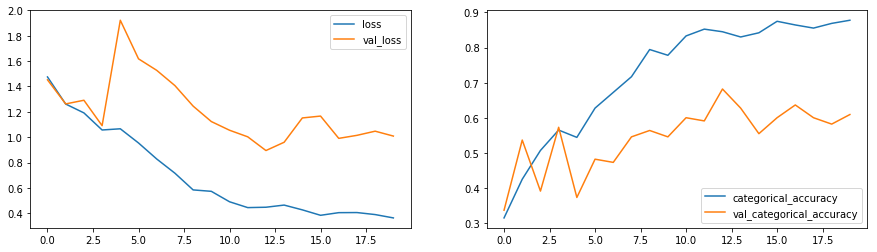

In [18]:
plot(lstm_training)

#### <font color= magenta> <u>Finding: </u> Training Accuracy = 87.78 ; Validation Accuracy = 60.91 </br> 

### <font color=green> <u>Model 1G: 2D Conv model with Bidirectional LSTM as the RNN model <a id='Step 1G'></a> 

In [19]:
def Conv2DBidirectLSTM(frames,rows,cols,channel):
    #2D Conv model with GRU as the RNN model 
    nb_featuremap = [8,16,32,64]
    nb_dense = [128,64,5]
    # Input
    input_shape=(frames,rows,cols,channel)

    bidirect_model = Sequential()

    bidirect_model.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))


    bidirect_model.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
    bidirect_model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    bidirect_model.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
    bidirect_model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    bidirect_model.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
    bidirect_model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    bidirect_model.add(TimeDistributed(BatchNormalization()))
    bidirect_model.add(Dropout(0.25))

    bidirect_model.add(TimeDistributed(Flatten()))

    bidirect_model.add(Dense(nb_dense[0], activation='relu'))
    bidirect_model.add(Dropout(0.25))
    bidirect_model.add(Dense(nb_dense[1], activation='relu'))
    bidirect_model.add(Dropout(0.25))

    ## using LSTM as the RNN model along with softmax as our last layer.
    bidirect_model.add(Bidirectional(LSTM(128, return_sequences=False)))
    bidirect_model.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
    return bidirect_model

In [20]:
bidirect_model = Conv2DBidirectLSTM(frames=30,rows=120,cols=120,channel=3)
optimiser =Adam(0.001) #write your optimizer
bidirect_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (bidirect_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 15, 15, 64)    8256      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 7, 7, 64)      0         
__________

In [21]:
callbacks_list = [checkpoint, LR]

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [22]:
batch_size = 11
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
bidir_lstm_training = bidirect_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,use_multiprocessing=True)

0
0
Epoch 1/20
1
1
2
2
3
3
 3/61 [>.............................] - ETA: 2:29 - loss: 1.6988 - categorical_accuracy: 0.24245
5
 5/61 [=>............................] - ETA: 1:45 - loss: 1.6610 - categorical_accuracy: 0.23646
6
 6/61 [=>............................] - ETA: 1:35 - loss: 1.5889 - categorical_accuracy: 0.30307
7
 7/61 [==>...........................] - ETA: 1:34 - loss: 1.6390 - categorical_accuracy: 0.28578
8
60/61 [============================>.] - ETA: 1s - loss: 1.0261 - categorical_accuracy: 0.58792
2
3
4
3
5
4
6
5
7
6
61/61 [==============================] - 85s 1s/step - loss: 1.0220 - categorical_accuracy: 0.5902 - val_loss: 1.2208 - val_categorical_accuracy: 0.5364

Epoch 00002: saving model to model_init_2020-06-2816_01_29.030839/model-00002-1.02200-0.59016-1.22079-0.53636.h5
Epoch 3/20
8
 2/61 [..............................] - ETA: 57s - loss: 0.6222 - categorical_accuracy: 0.77277
9
 3/61 [>.............................] - ETA: 56s - loss: 0.6734 - categorical

60/61 [============================>.] - ETA: 1s - loss: 0.1541 - categorical_accuracy: 0.95158
8
9
10
11
12
13
61/61 [==============================] - 85s 1s/step - loss: 0.1531 - categorical_accuracy: 0.9523 - val_loss: 1.3991 - val_categorical_accuracy: 0.6364

Epoch 00008: saving model to model_init_2020-06-2816_01_29.030839/model-00008-0.15312-0.95231-1.39910-0.63636.h5
Epoch 9/20
14
60/61 [============================>.] - ETA: 1s - loss: 0.1718 - categorical_accuracy: 0.94390
1
2
3
61/61 [==============================] - 83s 1s/step - loss: 0.1696 - categorical_accuracy: 0.9449 - val_loss: 1.5076 - val_categorical_accuracy: 0.6273

Epoch 00009: saving model to model_init_2020-06-2816_01_29.030839/model-00009-0.16965-0.94486-1.50763-0.62727.h5
4

Epoch 00009: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.
Epoch 10/20
60/61 [============================>.] - ETA: 1s - loss: 0.0590 - categorical_accuracy: 0.987910
11
12
13
14
15
61/61 [=======================

16
57/61 [===========================>..] - ETA: 4s - loss: 0.0481 - categorical_accuracy: 0.98723
4
5
6
61/61 [==============================] - 84s 1s/step - loss: 0.0467 - categorical_accuracy: 0.9881 - val_loss: 1.1487 - val_categorical_accuracy: 0.6727

Epoch 00011: saving model to model_init_2020-06-2816_01_29.030839/model-00011-0.04674-0.98808-1.14870-0.67273.h5
Epoch 12/20
60/61 [============================>.] - ETA: 1s - loss: 0.0423 - categorical_accuracy: 0.993912
13
14
15
16
17
61/61 [==============================] - 85s 1s/step - loss: 0.0421 - categorical_accuracy: 0.9940 - val_loss: 1.1318 - val_categorical_accuracy: 0.6727

Epoch 00012: saving model to model_init_2020-06-2816_01_29.030839/model-00012-0.04212-0.99404-1.13179-0.67273.h5
Epoch 13/20
18
 4/61 [>.............................] - ETA: 1:00 - loss: 0.0825 - categorical_accuracy: 0.97731
21
 6/61 [=>............................] - ETA: 57s - loss: 0.0643 - categorical_accuracy: 0.98482
22
 8/61 [==>...........

60/61 [============================>.] - ETA: 1s - loss: 0.0320 - categorical_accuracy: 0.99396
7
8
61/61 [==============================] - 84s 1s/step - loss: 0.0322 - categorical_accuracy: 0.9940 - val_loss: 1.0360 - val_categorical_accuracy: 0.7273

Epoch 00015: saving model to model_init_2020-06-2816_01_29.030839/model-00015-0.03216-0.99404-1.03603-0.72727.h5
Epoch 16/20
60/61 [============================>.] - ETA: 1s - loss: 0.0274 - categorical_accuracy: 0.997016
17
18
19
0
20
1
21
2
61/61 [==============================] - 83s 1s/step - loss: 0.0273 - categorical_accuracy: 0.9970 - val_loss: 0.9891 - val_categorical_accuracy: 0.7273

Epoch 00016: saving model to model_init_2020-06-2816_01_29.030839/model-00016-0.02730-0.99702-0.98912-0.72727.h5

Epoch 00016: ReduceLROnPlateau reducing learning rate to 4.0000002627493813e-07.
Epoch 17/20
3
22
 2/61 [..............................] - ETA: 55s - loss: 0.0141 - categorical_accuracy: 1.00004
23
 6/61 [=>............................

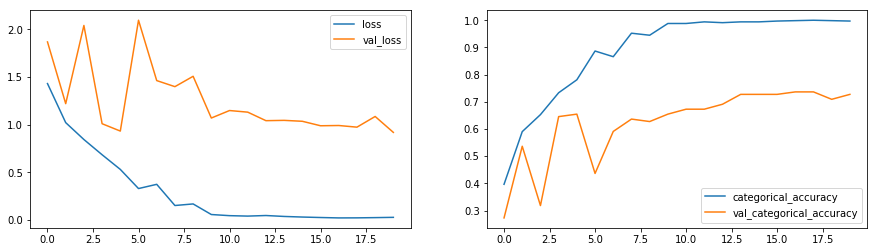

In [26]:
plot(bidir_lstm_training)

#### <font color= magenta> <u>Finding: Highest accuracy in 18th epoch</u> Training Accuracy =  99.73%; Validation Accuracy = 72.73% </br> 

### <font color=blue size=5> <u>MODEL 2: 3D Conv model

In [27]:
def Conv3DModel(frames=30,rows=120,cols=120,channel=3):
    #write your model here
    input_shape_is = (frames,rows,cols,channel)
    model = Sequential()
    model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape_is))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(nb_classes,activation='softmax'))
    return model

### <font color=green> <u>Model 2A: 3D Conv model with default arguments and batch_size=11

In [28]:
model = Conv3DModel()
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 60, 60, 32)    128       
__________

In [29]:
callbacks_list = [checkpoint, LR]

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [30]:
batch_size = 11
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [32]:
Conv3D_default = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

0
Epoch 1/20
0
1
1
2
2
3
3
 2/61 [..............................] - ETA: 3:30 - loss: 1.9770 - categorical_accuracy: 0.36364
4
 5/61 [=>............................] - ETA: 1:37 - loss: 2.2017 - categorical_accuracy: 0.25455
6
6
 7/61 [==>...........................] - ETA: 1:31 - loss: 2.1102 - categorical_accuracy: 0.27277
8
 8/61 [==>...........................] - ETA: 1:32 - loss: 2.1420 - categorical_accuracy: 0.27278
9
61/61 [==============================] - 63s 1s/step - loss: 1.6054 - categorical_accuracy: 0.4456 - val_loss: 1.0856 - val_categorical_accuracy: 0.6091

Epoch 00001: saving model to model_init_2020-06-2816_01_29.030839/model-00001-1.60541-0.44560-1.08559-0.60909.h5
Epoch 2/20
60/61 [============================>.] - ETA: 0s - loss: 1.1935 - categorical_accuracy: 0.55762
2
3
3
61/61 [==============================] - 59s 964ms/step - loss: 1.1846 - categorical_accuracy: 0.5604 - val_loss: 0.7928 - val_categorical_accuracy: 0.6818

Epoch 00002: saving model to model

61/61 [==============================] - 61s 995ms/step - loss: 0.7294 - categorical_accuracy: 0.7288 - val_loss: 0.8931 - val_categorical_accuracy: 0.6545

Epoch 00005: saving model to model_init_2020-06-2816_01_29.030839/model-00005-0.72943-0.72876-0.89307-0.65455.h5
Epoch 6/20
 5/61 [=>............................] - ETA: 1:06 - loss: 0.8235 - categorical_accuracy: 0.70910
1
60/61 [============================>.] - ETA: 0s - loss: 0.6312 - categorical_accuracy: 0.75306
6
7
7
61/61 [==============================] - 59s 967ms/step - loss: 0.6313 - categorical_accuracy: 0.7511 - val_loss: 1.1454 - val_categorical_accuracy: 0.5727

Epoch 00006: saving model to model_init_2020-06-2816_01_29.030839/model-00006-0.63133-0.75112-1.14540-0.57273.h5
Epoch 7/20
 2/61 [..............................] - ETA: 47s - loss: 0.7514 - categorical_accuracy: 0.72738
9
61/61 [==============================] - 60s 980ms/step - loss: 0.6789 - categorical_accuracy: 0.7332 - val_loss: 1.4640 - val_categorica

60/61 [============================>.] - ETA: 0s - loss: 0.5541 - categorical_accuracy: 0.78790
1
61/61 [==============================] - 59s 965ms/step - loss: 0.5664 - categorical_accuracy: 0.7869 - val_loss: 0.7990 - val_categorical_accuracy: 0.6909

Epoch 00009: saving model to model_init_2020-06-2816_01_29.030839/model-00009-0.56643-0.78689-0.79904-0.69091.h5
Epoch 10/20
60/61 [============================>.] - ETA: 0s - loss: 0.5567 - categorical_accuracy: 0.800010
11
61/61 [==============================] - 60s 978ms/step - loss: 0.5574 - categorical_accuracy: 0.7988 - val_loss: 0.6062 - val_categorical_accuracy: 0.8000

Epoch 00010: saving model to model_init_2020-06-2816_01_29.030839/model-00010-0.55744-0.79881-0.60617-0.80000.h5
Epoch 11/20
12
 8/61 [==>...........................] - ETA: 1:10 - loss: 0.5870 - categorical_accuracy: 0.750019
0
10/61 [===>..........................] - ETA: 1:08 - loss: 0.5259 - categorical_accuracy: 0.78181
21
60/61 [==========================

 4/61 [>.............................] - ETA: 55s - loss: 0.3749 - categorical_accuracy: 0.81820
19
 5/61 [=>............................] - ETA: 1:01 - loss: 0.3287 - categorical_accuracy: 0.854520
1
 7/61 [==>...........................] - ETA: 1:01 - loss: 0.4225 - categorical_accuracy: 0.81822
22
 8/61 [==>...........................] - ETA: 1:03 - loss: 0.4863 - categorical_accuracy: 0.79553
23
 9/61 [===>..........................] - ETA: 1:04 - loss: 0.5002 - categorical_accuracy: 0.78794
24
10/61 [===>..........................] - ETA: 1:06 - loss: 0.4736 - categorical_accuracy: 0.80005
25
61/61 [==============================] - 60s 977ms/step - loss: 0.4392 - categorical_accuracy: 0.8390 - val_loss: 0.4715 - val_categorical_accuracy: 0.8273

Epoch 00015: saving model to model_init_2020-06-2816_01_29.030839/model-00015-0.43917-0.83905-0.47145-0.82727.h5
Epoch 16/20
7
60/61 [============================>.] - ETA: 0s - loss: 0.4240 - categorical_accuracy: 0.853016
17
61/61 [====

61/61 [==============================] - 60s 987ms/step - loss: 0.3878 - categorical_accuracy: 0.8659 - val_loss: 0.4657 - val_categorical_accuracy: 0.8364

Epoch 00019: saving model to model_init_2020-06-2816_01_29.030839/model-00019-0.38783-0.86587-0.46575-0.83636.h5
Epoch 20/20
60/61 [============================>.] - ETA: 0s - loss: 0.3839 - categorical_accuracy: 0.872720
2
21
3
61/61 [==============================] - 58s 945ms/step - loss: 0.3830 - categorical_accuracy: 0.8703 - val_loss: 0.5269 - val_categorical_accuracy: 0.8182

Epoch 00020: saving model to model_init_2020-06-2816_01_29.030839/model-00020-0.38303-0.87034-0.52694-0.81818.h5


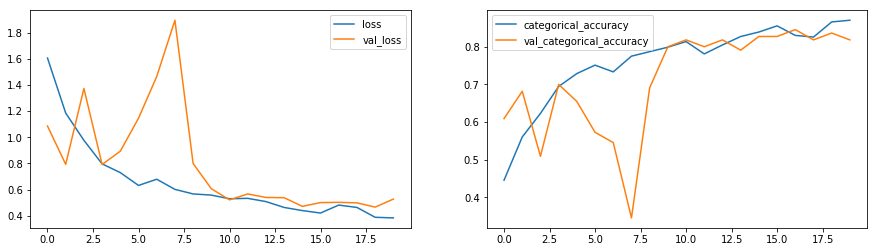

In [33]:
plot(Conv3D_default)

#### <font color= magenta> <u>Finding: Highest accuracy in 17th epoch</u> Training Accuracy =  83%; Validation Accuracy = 84% </br> 

### <font color=green> <u>Model 2B: 3D Conv model with image dimesion 100*100 and batch_size=20

In [34]:
model = Conv3DModel(rows=100,cols=100)
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 30, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 50, 50, 32)    4128      
_________________________________________________________________
activation_6 (Activation)    (None, 15, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 50, 50, 32)    128       
__________

In [35]:
batch_size = 20
train_generator = generator(train_path, train_doc, batch_size, rows=100, cols = 100)
val_generator = generator(val_path, val_doc, batch_size, rows =100, cols = 100)

In [36]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [37]:
Conv3D_2A = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

0
Epoch 1/200

1
1
2
2
 2/34 [>.............................] - ETA: 2:30 - loss: 2.0861 - categorical_accuracy: 0.22503
3
 3/34 [=>............................] - ETA: 1:51 - loss: 1.9999 - categorical_accuracy: 0.23334
4
34/34 [==============================] - 69s 2s/step - loss: 1.5574 - categorical_accuracy: 0.4088 - val_loss: 3.0607 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2020-06-2816_01_29.030839/model-00001-1.55741-0.40882-3.06072-0.36000.h5
1
Epoch 2/20
34/34 [==============================] - 56s 2s/step - loss: 1.1177 - categorical_accuracy: 0.5662 - val_loss: 1.1081 - val_categorical_accuracy: 0.5900

Epoch 00002: saving model to model_init_2020-06-2816_01_29.030839/model-00002-1.11766-0.56618-1.10815-0.59000.h5
Epoch 3/20
3
34/34 [==============================] - 58s 2s/step - loss: 0.9288 - categorical_accuracy: 0.6426 - val_loss: 1.6953 - val_categorical_accuracy: 0.4400

Epoch 00003: saving model to model_init_2020-06-2816_01_29.0308

34/34 [==============================] - 57s 2s/step - loss: 0.5185 - categorical_accuracy: 0.8074 - val_loss: 0.8763 - val_categorical_accuracy: 0.6500

Epoch 00008: saving model to model_init_2020-06-2816_01_29.030839/model-00008-0.51848-0.80735-0.87634-0.65000.h5
Epoch 9/20
9
34/34 [==============================] - 58s 2s/step - loss: 0.4735 - categorical_accuracy: 0.8353 - val_loss: 0.7500 - val_categorical_accuracy: 0.6800

Epoch 00009: saving model to model_init_2020-06-2816_01_29.030839/model-00009-0.47354-0.83529-0.75002-0.68000.h5
Epoch 10/20
34/34 [==============================] - 58s 2s/step - loss: 0.4747 - categorical_accuracy: 0.8279 - val_loss: 0.6961 - val_categorical_accuracy: 0.7500

Epoch 00010: saving model to model_init_2020-06-2816_01_29.030839/model-00010-0.47473-0.82794-0.69612-0.75000.h5
Epoch 11/20
11
34/34 [==============================] - 58s 2s/step - loss: 0.4698 - categorical_accuracy: 0.8221 - val_loss: 0.6723 - val_categorical_accuracy: 0.7600

Epoch

34/34 [==============================] - 57s 2s/step - loss: 0.4337 - categorical_accuracy: 0.8456 - val_loss: 0.6091 - val_categorical_accuracy: 0.7900

Epoch 00016: saving model to model_init_2020-06-2816_01_29.030839/model-00016-0.43373-0.84559-0.60910-0.79000.h5
Epoch 17/20
17
34/34 [==============================] - 58s 2s/step - loss: 0.4541 - categorical_accuracy: 0.8382 - val_loss: 0.6066 - val_categorical_accuracy: 0.7900

Epoch 00017: saving model to model_init_2020-06-2816_01_29.030839/model-00017-0.45407-0.83824-0.60665-0.79000.h5
Epoch 18/20
34/34 [==============================] - 57s 2s/step - loss: 0.4130 - categorical_accuracy: 0.8544 - val_loss: 0.6073 - val_categorical_accuracy: 0.7900

Epoch 00018: saving model to model_init_2020-06-2816_01_29.030839/model-00018-0.41298-0.85441-0.60728-0.79000.h5
Epoch 19/20
19
34/34 [==============================] - 57s 2s/step - loss: 0.4408 - categorical_accuracy: 0.8412 - val_loss: 0.6021 - val_categorical_accuracy: 0.7800



Epoch 00019: saving model to model_init_2020-06-2816_01_29.030839/model-00019-0.44078-0.84118-0.60212-0.78000.h5
Epoch 20/20
34/34 [==============================] - 59s 2s/step - loss: 0.3746 - categorical_accuracy: 0.8779 - val_loss: 0.6018 - val_categorical_accuracy: 0.7900

Epoch 00020: saving model to model_init_2020-06-2816_01_29.030839/model-00020-0.37459-0.87794-0.60183-0.79000.h5


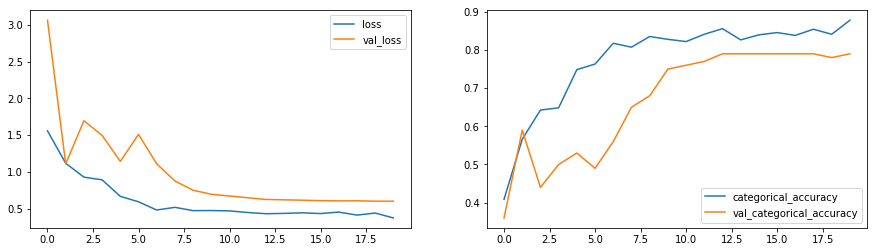

In [38]:
plot(Conv3D_2A)

#### <font color= magenta> <u>Finding: Highest accuracy in 20th epoch</u> Training Accuracy =  87%; Validation Accuracy = 79% </br> 

### <font color=green> <u>Model 2C: 3D Conv model without DropOuts

In [39]:
def Conv3DModelNoDropOut(frames=30,rows=120,cols=120,channel=3):
    #write your model here
    input_shape_is = (frames,rows,cols,channel)
    model_2 = Sequential()
    model_2.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape_is))
    model_2.add(Activation('relu'))
    model_2.add(BatchNormalization())
    model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model_2.add(Conv3D(32, (2, 2, 2), padding='same'))
    model_2.add(Activation('relu'))
    model_2.add(BatchNormalization())
    model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model_2.add(Conv3D(64, (2, 2, 2), padding='same'))
    model_2.add(Activation('relu'))
    model_2.add(BatchNormalization())
    model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model_2.add(Conv3D(128, (2, 2, 2), padding='same'))
    model_2.add(Activation('relu'))
    model_2.add(BatchNormalization())
    model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model_2.add(Flatten())
    model_2.add(Dense(128,activation='relu'))
    model_2.add(BatchNormalization())

    model_2.add(Dense(64,activation='relu'))
    model_2.add(BatchNormalization())

    model_2.add(Dense(nb_classes,activation='softmax'))
    return model_2

In [40]:
model_2 = Conv3DModelNoDropOut()
optimiser = optimizers.Adam()
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_10 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 15, 60, 60, 32)    128       
__________

In [41]:
batch_size = 11
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [42]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [43]:
Conv3D_2B = model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

0
Epoch 1/20
0
1
1
2
2
3
3
 4/61 [>.............................] - ETA: 1:46 - loss: 2.1788 - categorical_accuracy: 0.38645
5
 6/61 [=>............................] - ETA: 1:36 - loss: 2.0439 - categorical_accuracy: 0.36366
7
 7/61 [==>...........................] - ETA: 1:31 - loss: 2.0334 - categorical_accuracy: 0.32477
8
 8/61 [==>...........................] - ETA: 1:28 - loss: 2.0243 - categorical_accuracy: 0.31829
8
61/61 [==============================] - 64s 1s/step - loss: 1.3225 - categorical_accuracy: 0.5067 - val_loss: 1.5744 - val_categorical_accuracy: 0.4636

Epoch 00001: saving model to model_init_2020-06-2816_01_29.030839/model-00001-1.32249-0.50671-1.57436-0.46364.h5
Epoch 2/20
60/61 [============================>.] - ETA: 0s - loss: 0.6368 - categorical_accuracy: 0.78482
2
3
3
61/61 [==============================] - 57s 932ms/step - loss: 0.6300 - categorical_accuracy: 0.7869 - val_loss: 1.4671 - val_categorical_accuracy: 0.5636

Epoch 00002: saving model to model_i

61/61 [==============================] - 60s 991ms/step - loss: 0.3324 - categorical_accuracy: 0.8793 - val_loss: 2.7324 - val_categorical_accuracy: 0.3182

Epoch 00005: saving model to model_init_2020-06-2816_01_29.030839/model-00005-0.33237-0.87928-2.73242-0.31818.h5
Epoch 6/20
60/61 [============================>.] - ETA: 0s - loss: 0.2892 - categorical_accuracy: 0.88646
6
7
61/61 [==============================] - 61s 996ms/step - loss: 0.2866 - categorical_accuracy: 0.8882 - val_loss: 0.7925 - val_categorical_accuracy: 0.7455

Epoch 00006: saving model to model_init_2020-06-2816_01_29.030839/model-00006-0.28662-0.88823-0.79252-0.74545.h5
Epoch 7/20
7
 2/61 [..............................] - ETA: 29s - loss: 0.1598 - categorical_accuracy: 1.00008
9
61/61 [==============================] - 61s 1s/step - loss: 0.2643 - categorical_accuracy: 0.9121 - val_loss: 1.2803 - val_categorical_accuracy: 0.6364

Epoch 00007: saving model to model_init_2020-06-2816_01_29.030839/model-00007-0.264

60/61 [============================>.] - ETA: 0s - loss: 0.1870 - categorical_accuracy: 0.93640
1
61/61 [==============================] - 60s 987ms/step - loss: 0.1844 - categorical_accuracy: 0.9374 - val_loss: 0.8907 - val_categorical_accuracy: 0.7182

Epoch 00009: saving model to model_init_2020-06-2816_01_29.030839/model-00009-0.18439-0.93741-0.89067-0.71818.h5
Epoch 10/20
60/61 [============================>.] - ETA: 0s - loss: 0.1267 - categorical_accuracy: 0.962110
11
61/61 [==============================] - 60s 988ms/step - loss: 0.1271 - categorical_accuracy: 0.9627 - val_loss: 1.5825 - val_categorical_accuracy: 0.5364

Epoch 00010: saving model to model_init_2020-06-2816_01_29.030839/model-00010-0.12714-0.96274-1.58253-0.53636.h5
12

Epoch 00010: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.
Epoch 11/20
 9/61 [===>..........................] - ETA: 1:02 - loss: 0.1226 - categorical_accuracy: 0.96970
20
10/61 [===>..........................] - ETA: 1:03 -


Epoch 00014: saving model to model_init_2020-06-2816_01_29.030839/model-00014-0.07686-0.98361-0.65111-0.78182.h5
Epoch 15/20
16
 4/61 [>.............................] - ETA: 57s - loss: 0.0459 - categorical_accuracy: 1.000019
0
 5/61 [=>............................] - ETA: 1:05 - loss: 0.0415 - categorical_accuracy: 1.000020
1
 6/61 [=>............................] - ETA: 1:07 - loss: 0.0438 - categorical_accuracy: 1.000021
2
 7/61 [==>...........................] - ETA: 1:10 - loss: 0.1185 - categorical_accuracy: 0.97403
22
 8/61 [==>...........................] - ETA: 1:10 - loss: 0.1501 - categorical_accuracy: 0.95454
23
 9/61 [===>..........................] - ETA: 1:09 - loss: 0.1377 - categorical_accuracy: 0.95965
24
61/61 [==============================] - 60s 981ms/step - loss: 0.1129 - categorical_accuracy: 0.9702 - val_loss: 0.6975 - val_categorical_accuracy: 0.7455

Epoch 00015: saving model to model_init_2020-06-2816_01_29.030839/model-00015-0.11289-0.97019-0.69745-0.74545

61/61 [==============================] - 60s 977ms/step - loss: 0.0721 - categorical_accuracy: 0.9851 - val_loss: 0.5996 - val_categorical_accuracy: 0.7727

Epoch 00019: saving model to model_init_2020-06-2816_01_29.030839/model-00019-0.07214-0.98510-0.59963-0.77273.h5
Epoch 20/20
60/61 [============================>.] - ETA: 0s - loss: 0.0521 - categorical_accuracy: 0.993920
2
21
61/61 [==============================] - 60s 984ms/step - loss: 0.0522 - categorical_accuracy: 0.9940 - val_loss: 0.5739 - val_categorical_accuracy: 0.7909

Epoch 00020: saving model to model_init_2020-06-2816_01_29.030839/model-00020-0.05217-0.99404-0.57386-0.79091.h5
3


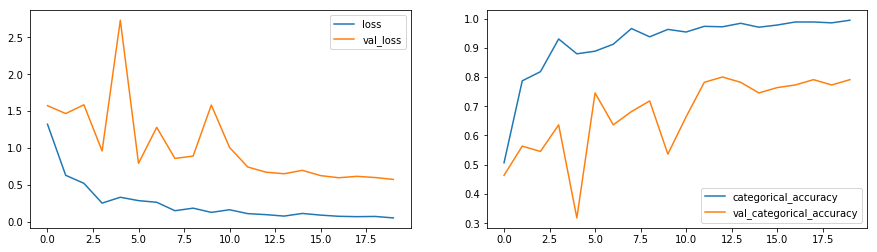

In [44]:
plot(Conv3D_2B)

#### <font color= magenta> <u>Finding: Highest accuracy in 13th epoch</u> Training Accuracy =  97%; Validation Accuracy = 80% </br> 

### <font color=green> <u>Model 2D: 3D Conv model wit DropOuts and without Batch Normalization

In [45]:
def Conv3DModelNoBatchNorm(frames=30,rows=120,cols=120,channel=3):
    #write your model here
    input_shape_is = (frames,rows,cols,channel)
    model = Sequential()
    model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape_is))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(nb_classes,activation='softmax'))
    return model

In [46]:
model_3 = Conv3DModelNoBatchNorm()
optimiser = optimizers.Adam()
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_14 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 7, 30, 30, 32)     0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 7, 30, 30, 64)     16448     
__________

In [47]:
batch_size = 11
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [48]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [49]:
Conv3D_2C = model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

0
Epoch 1/20
0
1
1
2
 3/61 [>.............................] - ETA: 1:30 - loss: 1.6900 - categorical_accuracy: 0.18183
4
 4/61 [>.............................] - ETA: 1:29 - loss: 1.6396 - categorical_accuracy: 0.20455
4
 5/61 [=>............................] - ETA: 1:26 - loss: 1.6077 - categorical_accuracy: 0.27276
5
 6/61 [=>............................] - ETA: 1:25 - loss: 1.6282 - categorical_accuracy: 0.24246
7
 7/61 [==>...........................] - ETA: 1:27 - loss: 1.6266 - categorical_accuracy: 0.24687
8
 8/61 [==>...........................] - ETA: 1:27 - loss: 1.6228 - categorical_accuracy: 0.26148
9
61/61 [==============================] - 61s 1s/step - loss: 1.6094 - categorical_accuracy: 0.2131 - val_loss: 1.5303 - val_categorical_accuracy: 0.2455

Epoch 00001: saving model to model_init_2020-06-2816_01_29.030839/model-00001-1.60943-0.21311-1.53032-0.24545.h5
Epoch 2/20
60/61 [============================>.] - ETA: 0s - loss: 1.5685 - categorical_accuracy: 0.27422
2
3
6

61/61 [==============================] - 60s 989ms/step - loss: 1.1964 - categorical_accuracy: 0.4605 - val_loss: 1.0519 - val_categorical_accuracy: 0.5091

Epoch 00005: saving model to model_init_2020-06-2816_01_29.030839/model-00005-1.19644-0.46051-1.05191-0.50909.h5
Epoch 6/20
60/61 [============================>.] - ETA: 0s - loss: 1.1330 - categorical_accuracy: 0.48646
6
7
61/61 [==============================] - 59s 975ms/step - loss: 1.1312 - categorical_accuracy: 0.4858 - val_loss: 1.1472 - val_categorical_accuracy: 0.5091

Epoch 00006: saving model to model_init_2020-06-2816_01_29.030839/model-00006-1.13117-0.48584-1.14723-0.50909.h5
Epoch 7/20
 1/61 [..............................] - ETA: 21s - loss: 1.1274 - categorical_accuracy: 0.36367
8
 2/61 [..............................] - ETA: 53s - loss: 1.2185 - categorical_accuracy: 0.45458
9
61/61 [==============================] - 60s 986ms/step - loss: 1.0572 - categorical_accuracy: 0.5216 - val_loss: 0.9353 - val_categorical_a

61/61 [==============================] - 60s 983ms/step - loss: 0.8956 - categorical_accuracy: 0.6140 - val_loss: 0.8003 - val_categorical_accuracy: 0.6727

Epoch 00009: saving model to model_init_2020-06-2816_01_29.030839/model-00009-0.89558-0.61401-0.80025-0.67273.h5
Epoch 10/20
1
60/61 [============================>.] - ETA: 0s - loss: 0.7568 - categorical_accuracy: 0.713610
11
61/61 [==============================] - 61s 997ms/step - loss: 0.7581 - categorical_accuracy: 0.7139 - val_loss: 0.7403 - val_categorical_accuracy: 0.7000

Epoch 00010: saving model to model_init_2020-06-2816_01_29.030839/model-00010-0.75812-0.71386-0.74029-0.70000.h5
Epoch 11/20
 9/61 [===>..........................] - ETA: 1:05 - loss: 0.8683 - categorical_accuracy: 0.60610
20
10/61 [===>..........................] - ETA: 1:03 - loss: 0.8787 - categorical_accuracy: 0.609121
1
61/61 [==============================] - 60s 985ms/step - loss: 0.7632 - categorical_accuracy: 0.6975 - val_loss: 0.7914 - val_categ

60/61 [============================>.] - ETA: 0s - loss: 0.4345 - categorical_accuracy: 0.830314
15
61/61 [==============================] - 59s 973ms/step - loss: 0.4419 - categorical_accuracy: 0.8256 - val_loss: 0.7887 - val_categorical_accuracy: 0.7364

Epoch 00014: saving model to model_init_2020-06-2816_01_29.030839/model-00014-0.44188-0.82563-0.78874-0.73636.h5
Epoch 15/20
 4/61 [>.............................] - ETA: 1:02 - loss: 0.2823 - categorical_accuracy: 0.88640
19
 5/61 [=>............................] - ETA: 1:09 - loss: 0.3307 - categorical_accuracy: 0.89091
20
 6/61 [=>............................] - ETA: 1:09 - loss: 0.3572 - categorical_accuracy: 0.87882
21
 7/61 [==>...........................] - ETA: 1:11 - loss: 0.3696 - categorical_accuracy: 0.88313
22
 8/61 [==>...........................] - ETA: 1:16 - loss: 0.3619 - categorical_accuracy: 0.87504
23
 9/61 [===>..........................] - ETA: 1:16 - loss: 0.4289 - categorical_accuracy: 0.85865
24
61/61 [=====

61/61 [==============================] - 60s 988ms/step - loss: 0.2462 - categorical_accuracy: 0.9076 - val_loss: 0.8500 - val_categorical_accuracy: 0.7636

Epoch 00019: saving model to model_init_2020-06-2816_01_29.030839/model-00019-0.24625-0.90760-0.85001-0.76364.h5
Epoch 20/20
60/61 [============================>.] - ETA: 0s - loss: 0.2398 - categorical_accuracy: 0.913620
2
21
61/61 [==============================] - 60s 984ms/step - loss: 0.2418 - categorical_accuracy: 0.9136 - val_loss: 0.9426 - val_categorical_accuracy: 0.7545

Epoch 00020: saving model to model_init_2020-06-2816_01_29.030839/model-00020-0.24177-0.91356-0.94255-0.75455.h5
3


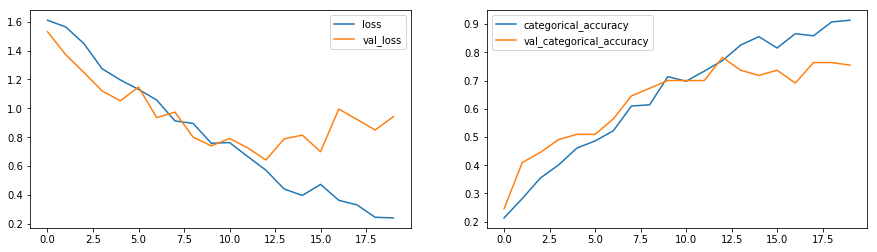

In [50]:
plot(Conv3D_2C)

#### <font color= magenta> <u>Finding: Highest accuracy in 19th epoch</u> Training Accuracy =  90%; Validation Accuracy = 76% </br> 

## BEST OF ALL IS MODEL 2A: 3D Conv model with default arguments and batch_size= 11